In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix

In [20]:
height = 1080
width = 1920
channels = 3
scale_factor = 0.2
scaled_height = int(height * scale_factor)
scaled_width = int(width * scale_factor)
input_shape = (scaled_height, scaled_width, channels)
batch_size = 16
epochs = 4
training_dir = 'data/training/'
validation_dir = 'data/validation/'

def image_count(directory):
    dir_abs_path = os.path.join(os.getcwd(), directory)
    count = 0
    for name in os.listdir(dir_abs_path):
        if os.path.isfile(os.path.join(dir_abs_path, name)):
            count += 1
    return count

num_training_samples = image_count(training_dir + 'train/') + image_count(training_dir + 'no_train/')
num_validation_samples = image_count(validation_dir + 'train/') + image_count(validation_dir + 'no_train/')

print("Scaled height: {}".format(scaled_height))
print("Scaled width: {}".format(scaled_width))
print("Input shape: {}".format(input_shape))
print("Batch size: {}".format(batch_size))
print("# epochs: {}".format(epochs))
print("# training samples: {}".format(num_training_samples))
print("# validation samples: {}".format(num_validation_samples))

Scaled height: 216
Scaled width: 384
Input shape: (216, 384, 3)
Batch size: 16
# epochs: 4
# training samples: 574
# validation samples: 476


In [21]:
# Instantiate the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 214, 382, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 107, 191, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 105, 189, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 52, 94, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 92, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 46, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36800)            

In [22]:
# Set up training and validation data
training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range = 30,
                                      width_shift_range = 0.3,
                                      height_shift_range = 0.3,
                                      horizontal_flip = True,
                                      fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_generator = training_datagen.flow_from_directory(
        'data/training/',
        target_size=(scaled_height, scaled_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        'data/validation/',
        target_size=(scaled_height, scaled_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 574 images belonging to 2 classes.
Found 476 images belonging to 2 classes.


In [23]:
# Train the model and save the weights
history = model.fit_generator(
    training_generator,
    steps_per_epoch = num_training_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = num_validation_samples // batch_size)
model.save_weights('train_detection_cnn.h5')

Epoch 1/4
35/35 [==============================] - 32s 918ms/step - loss: 1.6856 - accuracy: 0.6846 - val_loss: 0.5181 - val_accuracy: 0.7888
Epoch 2/4
35/35 [==============================] - 32s 912ms/step - loss: 0.5863 - accuracy: 0.7186 - val_loss: 0.4529 - val_accuracy: 0.8405
Epoch 3/4
35/35 [==============================] - 34s 985ms/step - loss: 0.5865 - accuracy: 0.7437 - val_loss: 0.3478 - val_accuracy: 0.8513
Epoch 4/4
35/35 [==============================] - 35s 1s/step - loss: 0.4292 - accuracy: 0.7975 - val_loss: 0.2740 - val_accuracy: 0.9030


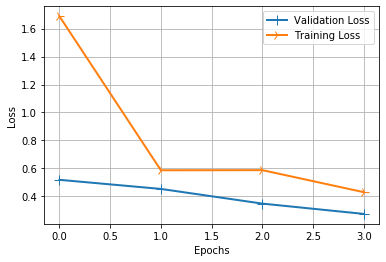

In [24]:
# Plot loss curves
# TODO: Currently there are clear signs of overfitting (with 25 epochs). Probably need more training data
# and maybe an additional dropout layer(s).
epochs_array = np.arange(epochs)
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
line1 = plt.plot(epochs_array, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs_array, loss_values, label='Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

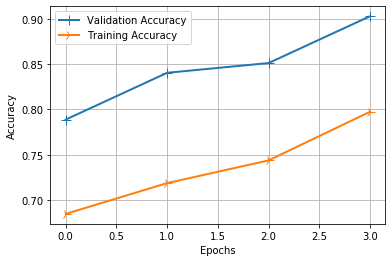

In [25]:
# Plot accuracy curves
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
line1 = plt.plot(epochs_array, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs_array, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [43]:
y_true = validation_generator.classes
y_pred = model.predict_generator(validation_generator).flatten()
class_idx_dict = validation_generator.class_indices
print('Class index for \'no_train\' is {}.'.format(class_idx_dict['no_train']))
print('Class index for \'train\' is {}.'.format(class_idx_dict['train']))

Class index for 'no_train' is 0.
Class index for 'train' is 1.


(476,)
Model said no_train/variety000279.jpg contained a train (0.875881552696228), but it didn't.


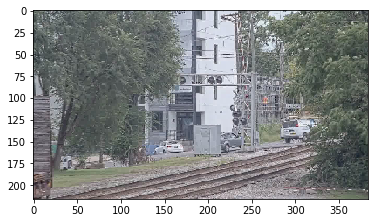

Model said no_train/variety000280.jpg contained a train (0.8722656965255737), but it didn't.


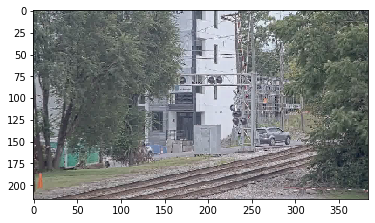

Model said no_train/variety000281.jpg contained a train (0.872366189956665), but it didn't.


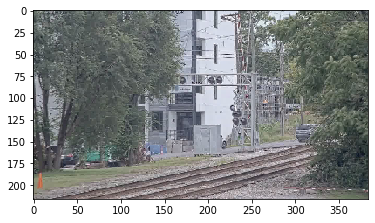

Model said no_train/variety000282.jpg contained a train (0.8690531253814697), but it didn't.


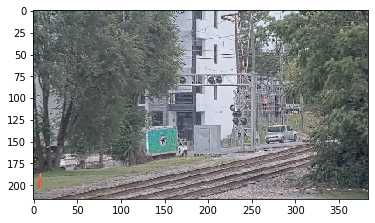

Model said no_train/variety000283.jpg contained a train (0.8701814413070679), but it didn't.


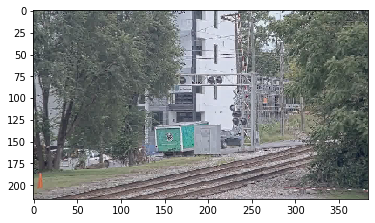

Model said no_train/variety000284.jpg contained a train (0.8691232204437256), but it didn't.


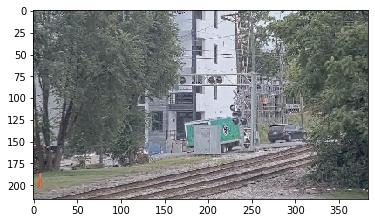

Model said no_train/variety000285.jpg contained a train (0.8691009879112244), but it didn't.


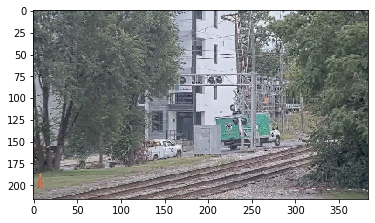

Model said no_train/variety000286.jpg contained a train (0.8741363286972046), but it didn't.


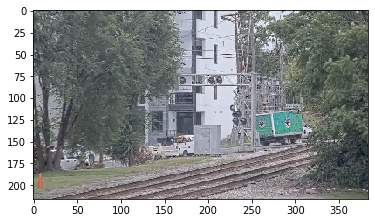

Model said no_train/variety000287.jpg contained a train (0.874180257320404), but it didn't.


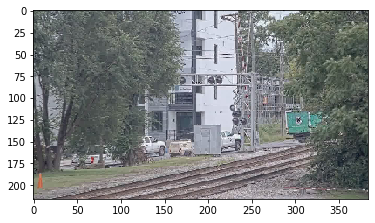

Model said no_train/variety000288.jpg contained a train (0.8727493286132812), but it didn't.


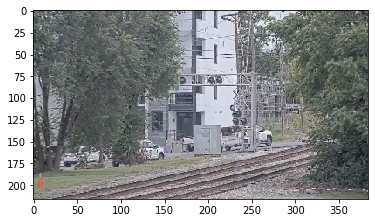

Model said no_train/variety000289.jpg contained a train (0.8735567331314087), but it didn't.


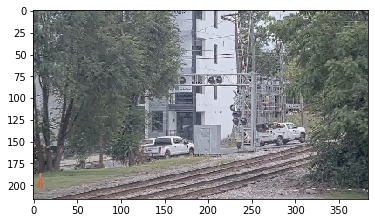

Model said no_train/variety000290.jpg contained a train (0.8715144395828247), but it didn't.


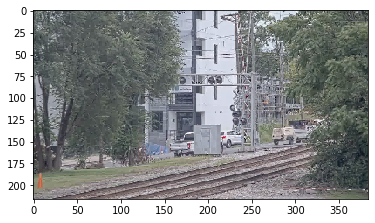

Model said no_train/variety000291.jpg contained a train (0.8720717430114746), but it didn't.


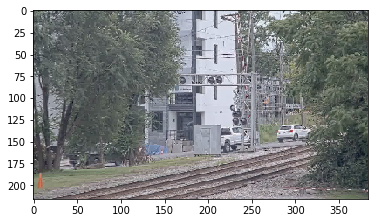

Model said no_train/variety000292.jpg contained a train (0.8742926120758057), but it didn't.


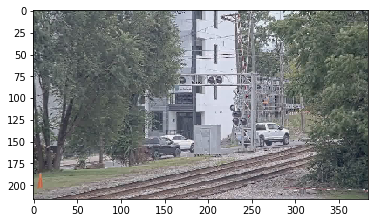

Model said no_train/variety000293.jpg contained a train (0.8736411333084106), but it didn't.


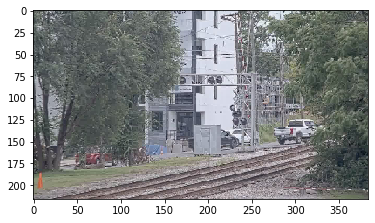

Model said no_train/variety000294.jpg contained a train (0.8760941028594971), but it didn't.


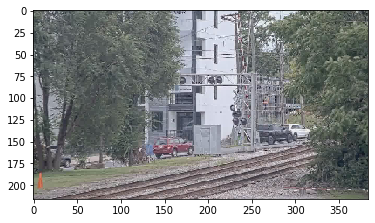

Model said no_train/variety000295.jpg contained a train (0.8736293911933899), but it didn't.


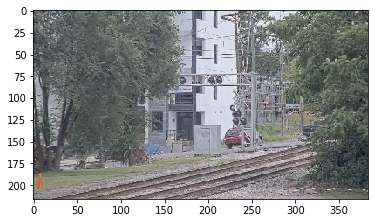

Model said no_train/variety000296.jpg contained a train (0.8749592304229736), but it didn't.


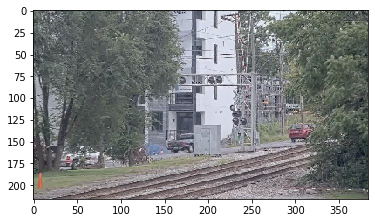

Model said no_train/variety000297.jpg contained a train (0.8715604543685913), but it didn't.


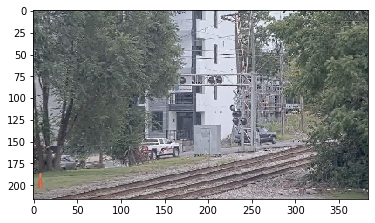

Model said no_train/variety000298.jpg contained a train (0.8709873557090759), but it didn't.


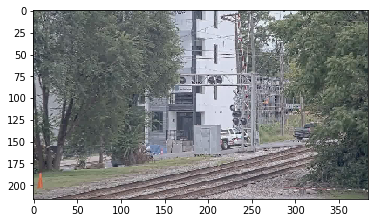

Model said no_train/variety000299.jpg contained a train (0.872010350227356), but it didn't.


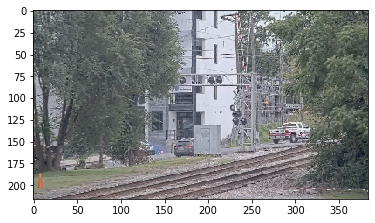

Model said no_train/variety000300.jpg contained a train (0.8731239438056946), but it didn't.


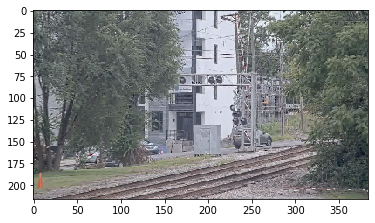

Model said no_train/variety000301.jpg contained a train (0.8715165257453918), but it didn't.


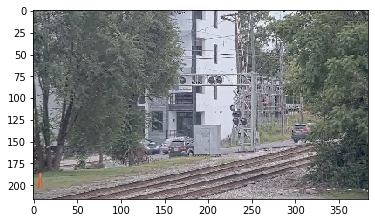

Model said no_train/variety000302.jpg contained a train (0.8726696968078613), but it didn't.


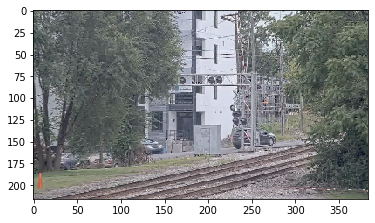

Model said no_train/variety000303.jpg contained a train (0.8730926513671875), but it didn't.


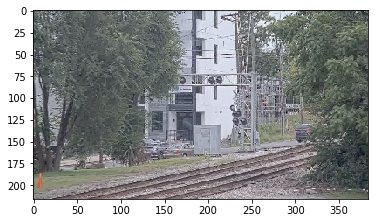

Model said no_train/variety000304.jpg contained a train (0.8734524250030518), but it didn't.


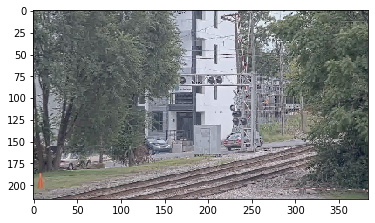

Model said no_train/variety000305.jpg contained a train (0.8745219707489014), but it didn't.


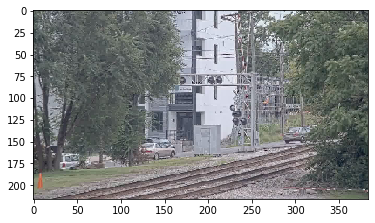

Model said no_train/variety000306.jpg contained a train (0.8733316659927368), but it didn't.


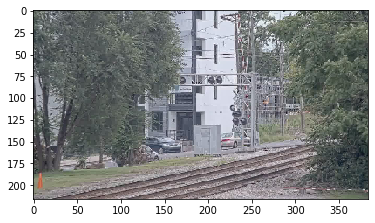

Model said no_train/variety000307.jpg contained a train (0.8734697103500366), but it didn't.


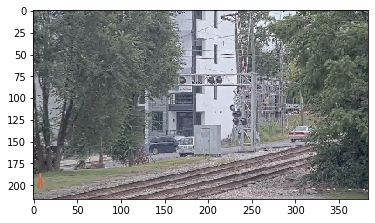

Model said no_train/variety000308.jpg contained a train (0.8715143203735352), but it didn't.


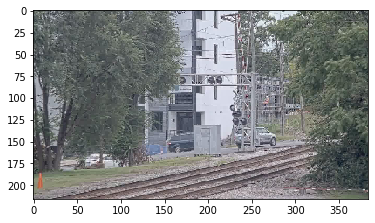

Model said no_train/variety000309.jpg contained a train (0.8735254406929016), but it didn't.


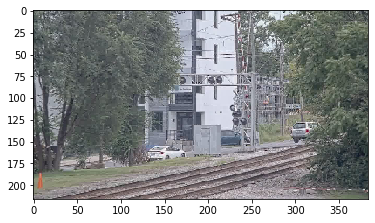

Model said no_train/variety000310.jpg contained a train (0.8722453713417053), but it didn't.


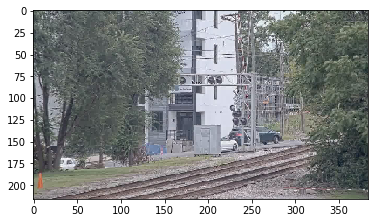

Model said no_train/variety000311.jpg contained a train (0.8713976740837097), but it didn't.


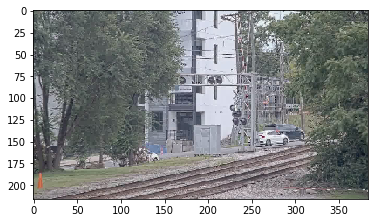

Model said no_train/variety000312.jpg contained a train (0.8718947768211365), but it didn't.


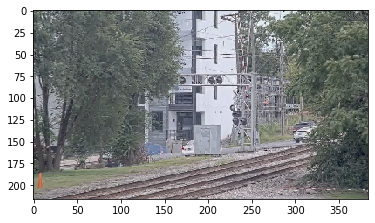

Model said no_train/variety000313.jpg contained a train (0.8709689378738403), but it didn't.


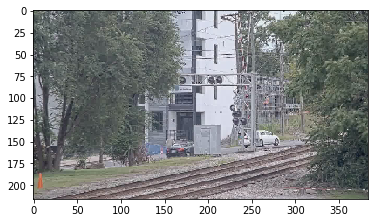

Model said no_train/variety000314.jpg contained a train (0.872205376625061), but it didn't.


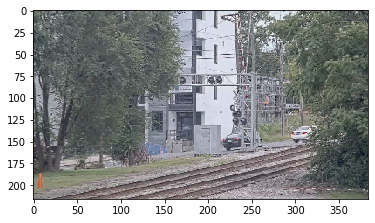

Model said no_train/variety000315.jpg contained a train (0.8726921081542969), but it didn't.


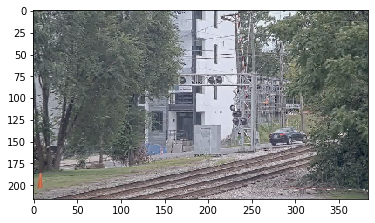

Model said no_train/variety000316.jpg contained a train (0.871864914894104), but it didn't.


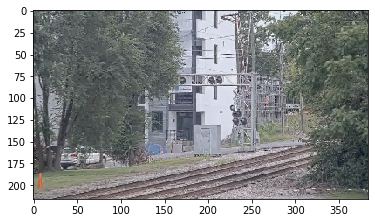

Model said no_train/variety000317.jpg contained a train (0.8740750551223755), but it didn't.


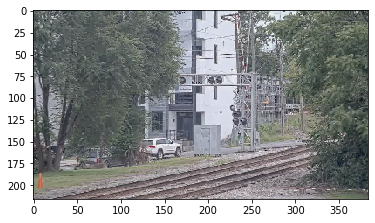

Model said no_train/variety000318.jpg contained a train (0.8733001947402954), but it didn't.


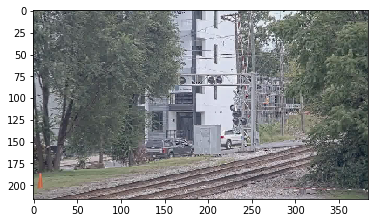

Model said no_train/variety000319.jpg contained a train (0.8721444010734558), but it didn't.


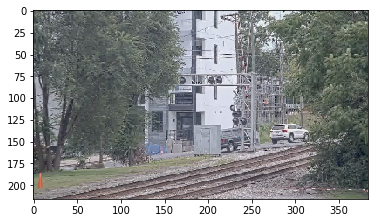

Model said no_train/variety000320.jpg contained a train (0.8719738721847534), but it didn't.


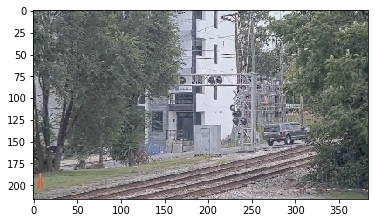

Model said no_train/variety000321.jpg contained a train (0.8708503246307373), but it didn't.


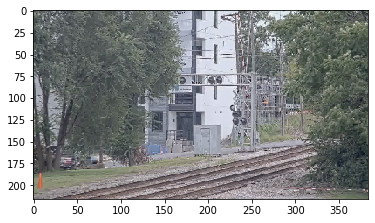

Model said no_train/variety000322.jpg contained a train (0.8744897842407227), but it didn't.


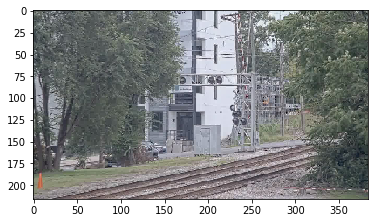

Model said no_train/variety000323.jpg contained a train (0.8728035688400269), but it didn't.


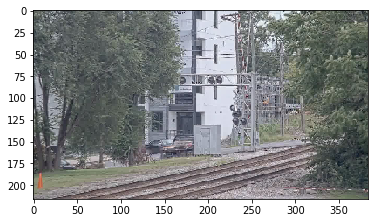

Misclassified 45 images.


In [44]:
# Round to nearest class label (1 "train" or 0 "no_train")
pred_class_idxs = np.around(y_pred)
filenames = validation_generator.filenames
miss_count = 0
for i in range(y_true.shape[0]):
    if int(pred_class_idxs[i]) != y_true[i]:
        miss_count += 1
        if y_true[i] == class_idx_dict['no_train']:
            print('Model said {} contained a train ({}), but it didn\'t.'.format(filenames[i], y_pred[i]))
        else:
            print('Model said {} did not contain a train ({}), but it did.'.format(filenames[i], y_pred[i]))
        batch_number = i // batch_size
        img_number = i % batch_size
        img = validation_generator[batch_number][0][img_number]
        plt.imshow(img)
        plt.show()

print('Misclassified {} images.'.format(miss_count))


In [45]:
cm = confusion_matrix(y_true, pred_class_idxs)
print('Confusion Matrix:')
print(cm)
true_negatives = cm[0][0]
false_negatives = cm[1][0]
true_positives = cm[1][1]
false_positives = cm[0][1]
print('True negatives: {}'.format(true_negatives))
print('False negatives: {}'.format(false_negatives))
print('True positives: {}'.format(true_positives))
print('False positives: {}'.format(false_positives))

Confusion Matrix:
[[ 53  45]
 [  0 378]]
True negatives: 53
False negatives: 0
True positives: 378
False positives: 45
